In [1]:
# ===================================================================
#                          METADATA
# ===================================================================

# -------------------- General Information --------------------------
# 1. Title: Figure Script
# 2. Description: Script to reproduce Figure SI 5 in the article
# "Ionic Liquid--Electrode Interface: from One Law To Fit Them All to One Model To Predict Them All".
# 3. Authors:
#    - Ba Long Nguyen (ORCID: 0009-0003-7682-9851)
#    - Vladislav Ivanistsev (ORCID: 0000-0003-4517-0540)
# 4. Contact: balongn99@gmail.com & vladislav.ivanistsev@gmail.com
# 5. Keywords: differential capacitance, ionic liquids, modelling, fitting.

# -------------------- Identifiers & Versioning ---------------------
# 6. Version: 1.0.0
# 7. Date: 
#    - Created: 2025-06-13
#    - Last Modified: 2025-09-24
# 8. DOI: https://doi.org/10.1016/j.elecom.2025.108049

# -------------------- Usage & Accessibility ------------------------
# 10. License: This work is licensed under the MIT License.
# 11. Dependencies:
#     - Python 3.8+
#     - See 'requirements.txt' for necessary libraries (e.g., numpy, pandas, scipy, matplotlib).
# 13. Data Format:
#     - Units: Potential (V), Capacitance (μF/cm²), Surface Charge Density (μC/cm²)

In [2]:
from cycler import cycler
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter1d

import numdifftools as nd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [3]:
l = 8.25/2.54 # inches
plt.rc('figure',figsize=(l,l)) # figure size
plt.rc('figure',      dpi=500) # figure dpi
plt.rc('lines',  linewidth=1)  # linewidth
plt.rc('font',        size=10) # fontsize of the text
plt.rc('font', family='sans-serif') # font family
plt.rc('axes',   titlesize=10) # fontsize of the axes title
plt.rc('axes',   labelsize=9)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=8)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=8)  # fontsize of the tick labels
plt.rc('legend', fontsize =7.5)  # fontsize of the legend
plt.rc('figure', titlesize=10) # fontsize of the figure title

In [7]:
# ──────────────────── POWER-LAW MODEL ────────────────────
EXCLUDE = np.nan
def a(u, u_M, s_M, k1, k2):
    expo = k1 + (1 - k1) * np.exp(-k2 * u / u_M)
    if s_M > 0:                         # only right half-plane allowed
        expo = np.where(u >= 0, expo, EXCLUDE)
    else:                               # only left half-plane allowed
        expo = np.where(u <= 0, expo, EXCLUDE)
    return expo
      
def s(u, u_M, s_M, k1, k2): 
  return s_M * abs(u / u_M)**a(u, u_M, s_M, k1, k2)

In [5]:
# ──────────────────── DATASETS ────────────────────
data_C2MImTFSA = {
  'Q': np.array( [-20.0441 , -18.8903 , -17.72776, -16.54825, -15.34412, -14.12206,
 -12.88747, -11.64166, -10.39072,  -9.14098,  -7.83381,  -6.42038,
  -4.8837 ,  -3.2193 ,  -1.44907,   0.38461,   4.33667,   6.36905,
   8.47922,  10.70047,  13.00924,  15.33761] ),
'U': np.array( [-1.48, -1.38, -1.28, -1.18, -1.08, -0.98, -0.88, -0.78, -0.68, -0.58,
 -0.48, -0.38, -0.28, -0.18, -0.08,  0.02,  0.22,  0.32,  0.42,  0.52,
  0.62,  0.72] ),
'C': np.array( [11.51724452, 11.60507712, 11.7420332 , 11.92118666, 12.1073372 ,
 12.26465704, 12.38350689, 12.47776336, 12.62997169, 13.01756648,
 13.76426483, 14.80593467, 15.96160735, 17.0502339 , 18.00919163,
 18.95461361, 19.92072709, 20.80251933, 21.66346772, 22.45845649,
 22.98135121, 23.18964684] )
}
data_C4MImTFSA = {
  'Q': np.array( [-19.1524    , -18.0745    , -17.0066    , -15.93275   , -14.84825   ,
 -13.7432    , -12.60265   , -11.4214    , -10.20705   ,  -8.9657    ,
  -7.71115   ,  -6.4434    ,  -5.1702    ,  -3.9124    ,  -2.6485    ,
  -1.3492    ,   0.        ,   1.4887    ,   3.2117    ,   5.1362    ,
   7.17715   ,   9.3385    ,  11.63345   ,  13.986     ,  16.34958126,
  18.70746719] ),
'U': np.array( [-1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5,
 -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
  0.8,  0.9] ),
'C': np.array( [10.95875749, 10.81408461, 10.76557635, 10.83422554, 11.00439097,
 11.27177347, 11.60679145, 11.94618832, 12.23336153, 12.44465855,
 12.5835655 , 12.65136861, 12.66411127, 12.71685229, 12.94903145,
 13.50659748, 14.57568353, 16.19290301, 18.02186252, 19.64790835,
 20.99153146, 22.13044877, 22.97471041, 23.42116023, 23.56168894,
 23.57184719] )
}
data_C6MImTFSA = {
  'Q': np.array( [-13.22644, -12.16943, -11.13515, -10.10869,  -9.06828,  -8.01445,
  -6.94381,  -5.85806,  -4.76217,  -3.65011,  -2.51384,  -1.31476,
   0.     ,   1.45082,   3.0655 ,   4.82748,   6.74476,   8.84195,
  11.10757,  13.50556,  15.89517,  18.16596] ),
'U': np.array( [-1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9] ),
'C': np.array( [10.68634176, 10.50455341, 10.38429328, 10.38607768, 10.48437651,
 10.6247769 , 10.77113079, 10.9136673 , 11.08247163, 11.36163883,
 11.88251686, 12.74796858, 13.94425957, 15.36303323, 16.88305681,
 18.45612145, 20.08699406, 21.67058379, 22.8994311 , 23.38735441,
 23.03142845, 22.25592275] )
}
# Create DataFrames
df_C2MImTFSA = pd.DataFrame(data_C2MImTFSA)
df_C4MImTFSA = pd.DataFrame(data_C4MImTFSA)
df_C6MImTFSA = pd.DataFrame(data_C6MImTFSA)
u_values = np.linspace(-10,10,1000)
# Parameters for the anions and cations
params = {
    "TFSA2": {
        's_M' : 41.4, 'u_M' : 2.5742, 'k1': 0, 'k2': 0.864368
    },
    "C2Im": {
        's_M' : -46 , 'u_M' : -3.982, 'k1': 0.84062, 'k2': 55.4
    },
    "TFSA4": {
        's_M' : 41.4, 'u_M' : 3.9461, 'k1': 0, 'k2': 2.662890
    },
    "C4Im": {
        's_M' : -44.9 , 'u_M' : -4.14 , 'k1': 0.893625, 'k2': 13.817
    },
    "TFSA6": {
        's_M' : 41.4, 'u_M' : 4.4298,  'k1': 0, 'k2': 3.188236
    },
    "C6Im": {
        's_M' : -44.9 , 'u_M' : -4.488, 'k1': 0.927764, 'k2': 235.1
    }
}


/tmp/ipykernel_11650/2994751622.py:28: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(
/tmp/ipykernel_11650/2994751622.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(
/tmp/ipykernel_11650/2994751622.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


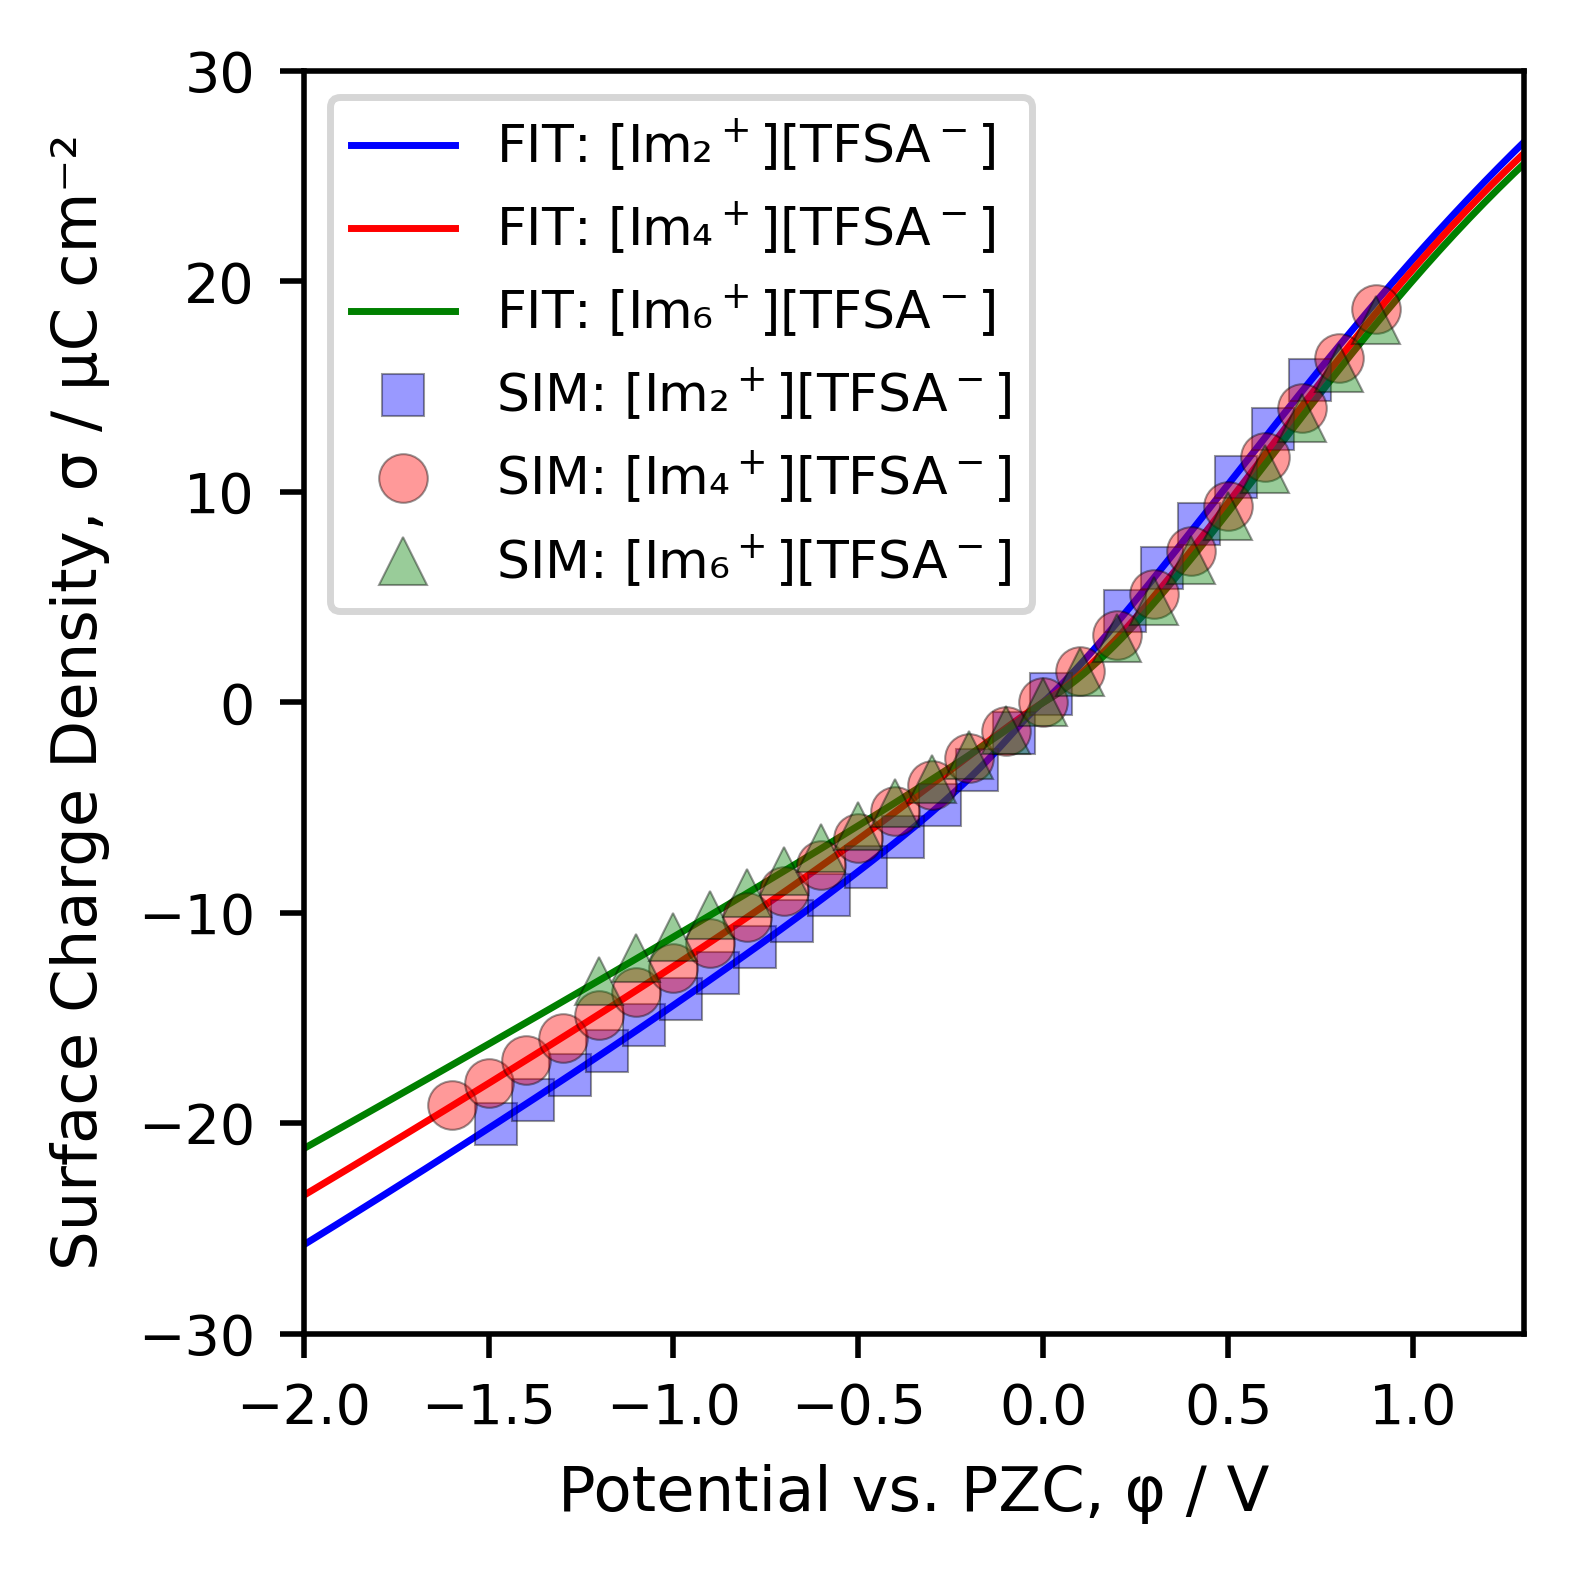

In [6]:
s_values = {}

for ion, param in params.items():
    s_values[ion] = [s(u, param['u_M'], param['s_M'], param['k1'], param['k2']) for u in u_values]
  
joint_sdata = {}

joint_sdata["FIT: $\\mathrm{[Im₂^+][TFSA^-]}$"] = np.concatenate((np.asarray(s_values['C2Im'])[~np.isnan(np.asarray(s_values['C2Im']))],
                                            np.asarray(s_values['TFSA2'])[~np.isnan(np.asarray(s_values['TFSA2']))]
                                           ))
joint_sdata["FIT: $\\mathrm{[Im₄^+][TFSA^-]}$"] = np.concatenate((np.asarray(s_values['C4Im'])[~np.isnan(np.asarray(s_values['C4Im']))],
                                            np.asarray(s_values['TFSA4'])[~np.isnan(np.asarray(s_values['TFSA4']))]
                                           ))
joint_sdata["FIT: $\\mathrm{[Im₆^+][TFSA^-]}$"] = np.concatenate((np.asarray(s_values['C6Im'])[~np.isnan(np.asarray(s_values['C6Im']))],
                                            np.asarray(s_values['TFSA6'])[~np.isnan(np.asarray(s_values['TFSA6']))]
                                           ))

plt.figure()

for label, data in joint_sdata.items():
    if '$\\mathrm{[Im₂^+][TFSA^-]}$' in label:
        plt.plot(u_values, data, label=label, color='blue', linewidth=1)
    if '$\\mathrm{[Im₄^+][TFSA^-]}$' in label:
        plt.plot(u_values, data, label=label, color='red', linewidth=1)
    if '$\\mathrm{[Im₆^+][TFSA^-]}$' in label:
        plt.plot(u_values, data, label=label, color='green', linewidth=1)

plt.errorbar(
    (df_C2MImTFSA['U']), df_C2MImTFSA['Q'], fmt='o', color='blue', label='SIM: $\\mathrm{[Im₂^+][TFSA^-]}$', marker='s', markersize=6, markeredgecolor='black', markeredgewidth=0.3, alpha=0.4
)
plt.errorbar(
    (df_C4MImTFSA['U']), df_C4MImTFSA['Q'], fmt='o', color='red', label='SIM: $\\mathrm{[Im₄^+][TFSA^-]}$', marker='o', markersize=7, markeredgecolor='black', markeredgewidth=0.3, alpha=0.4
)
plt.errorbar(
    (df_C6MImTFSA['U']), df_C6MImTFSA['Q'], fmt='o', color='green', label='SIM: $\\mathrm{[Im₆^+][TFSA^-]}$', marker='^', markersize=7, markeredgecolor='black', markeredgewidth=0.3, alpha=0.4
)
  

plt.axvline(x=params['C2Im']['u_M'], color='blue', linestyle='--', linewidth = 0.4)
plt.axvline(x=params['TFSA2']['u_M'], color='blue', linestyle='--', linewidth = 0.4)
plt.axvline(x=params['C4Im']['u_M'], color='red', linestyle='--', linewidth = 0.4)
plt.axvline(x=params['TFSA4']['u_M'], color='red', linestyle='--', linewidth = 0.4)
plt.axvline(x=params['C6Im']['u_M'], color='#cc00ffff', linestyle='--', linewidth = 0.4)
plt.axvline(x=params['TFSA6']['u_M'], color='#cc00ffff', linestyle='--', linewidth = 0.4)
plt.xlabel('Potential vs. PZC, φ / V')
plt.ylabel('Surface Charge Density, σ / μC cm⁻²')
plt.legend(loc='upper left')
plt.xlim(-2, 1.3)
plt.ylim(-30, 30)
plt.tight_layout()
# plt.savefig("Figure_SI5_experiment_Costa.pdf", dpi=600, bbox_inches='tight')
plt.show()